# Layer-wise Relevance Propagation using Abstract Semiring elements for the MNIST Dataset

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision.transforms import ToTensor

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import ProvLRP
import ProvLRP_config
from importlib import reload
reload(ProvLRP)

<module 'ProvLRP' from '/Users/antoinegroudiev/Documents/Travail/L3-Internship/code/ProvLRP.py'>

## 0. Load dataset

In [2]:
# Load dataset

train = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [5]:
BATCH_SIZE = 32

train_dataloader = DataLoader(
    train,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    test,
    batch_size=BATCH_SIZE,
    shuffle=False
)

## 1. Train simple model

In [6]:
# Select the best device to use

if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(f'Using device: {device}')

Using device: mps


In [7]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    return correct / len(y_pred) * 100

In [82]:
def train_model(model, optimizer, loss_fn):
    epochs = 1#3

    for epoch in range(epochs):
        print(f"[EPOCH {epoch+1}/{epochs}] ", end="")
        train_loss = 0

        for batch, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)
            model.train()

            y_pred = model(X)

            loss = loss_fn(y_pred, y)
            train_loss += loss

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

        train_loss /= len(train_dataloader)

        test_loss, test_acc = 0, 0
        model.eval()
        with torch.inference_mode():
            for X, y in test_dataloader:
                X, y = X.to(device), y.to(device)
                test_pred = model(X)

                test_loss += loss_fn(test_pred, y)
                test_acc += accuracy_fn(y, test_pred.argmax (dim=1))

            test_loss /= len(test_dataloader)
            test_acc /= len(test_dataloader)

        print(f"Train loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

In [103]:
# Build the model
inputs = 784
hidden1 = 300
hidden2 = 100
outputs = 10

assert(outputs == len(train.classes))

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(inputs, hidden1),
    nn.ReLU(),
    nn.Linear(hidden1, hidden2),
    nn.ReLU(),
    nn.Linear(hidden2, outputs)
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

In [104]:
train_model(model, optimizer, loss_fn)

[EPOCH 1/1] Train loss: 0.35428 | Test loss: 0.15230, Test acc: 95.15%


## 3. Network pruning using Semiring-based LRP

In [51]:
nb_digits = len(train.classes)

# Extract weights and biases of trained MLP
layers = list(filter(None, [layer if isinstance(layer, nn.Linear) else None for layer in model.children()]))
W = [layer.weight.to('cpu').detach().numpy().T for layer in layers]
B = [layer.bias.to('cpu').detach().numpy().T for layer in layers]
L = len(W)

X = train.data.reshape((60000, 784)).detach().numpy()
T = train.targets.detach().numpy()

SUBSET = 20
X = X[:SUBSET]
T = T[:SUBSET]

# Forward pass
A = [X] + [None] * L
for l in range(L):
    A[l+1] = np.maximum(0, A[l].dot(W[l])+B[l])

In [52]:
reload(ProvLRP)
reload(ProvLRP_config)
semiring = ProvLRP.BooleanSemiring

ProvLRP_config.boolean_relevance_threshold = 0.5

ProvLRP_config.boolean_activation_threshold = 1
ProvLRP_config.boolean_weight_threshold = 0

R_bool = [None] * L + [semiring.from_relevance(A[L] * (T[:,None]==np.arange(nb_digits)))]

# All layers, even the pixels one
for l in range(0, L)[::-1]:
    w = semiring.from_weight(W[l])

    s = R_bool[l+1]
    c = s.dot(w.T)
    R_bool[l] = semiring.from_activation(A[l]) * c

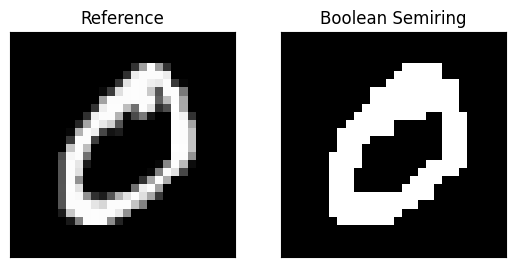

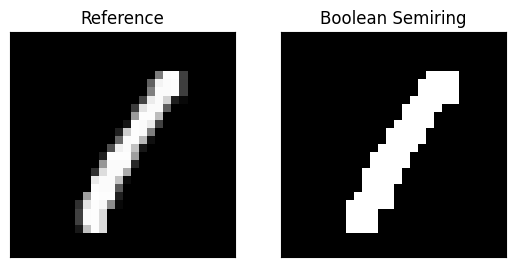

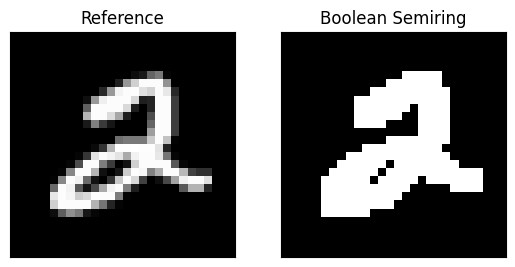

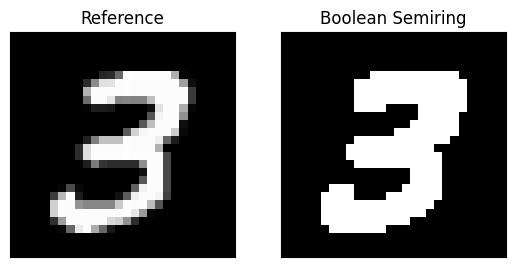

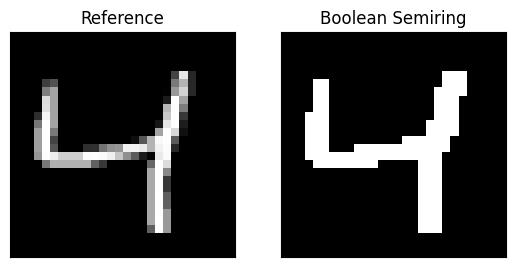

In [53]:
Rf = [semiring.semiring_to_float(x) for x in R_bool]

DIGITS = 5
for i in range(DIGITS):
    image = Rf[0][T==i][0].reshape((28, 28))

    fig, axs = plt.subplots(1, 2)
    for j in range(2):
        axs[j].set_xticks([]); axs[j].set_yticks([])

    axs[0].imshow(X[T==i][0].reshape((28, 28)), cmap="gray")
    axs[0].set_title("Reference")

    axs[1].imshow(image, cmap="gray", vmin=0, vmax=1)
    axs[1].set_title("Boolean Semiring")

    plt.show()

In [105]:
import torch.nn.utils.prune as prune
import torch.nn.functional as F

In [106]:
def eval_model(m):
    test_loss, test_acc = 0, 0
    m.eval()
    with torch.inference_mode():
        for x, y in test_dataloader:
            x, y = x.to(device), y.to(device)
            test_pred = m(x)

            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y, test_pred.argmax (dim=1))

        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)

    print(f"Test loss: {test_loss:.3f} | Test accuracy: {test_acc:.2f}%")

In [112]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(inputs, hidden1),
    nn.ReLU(),
    nn.Linear(hidden1, hidden2),
    nn.ReLU(),
    nn.Linear(hidden2, outputs)
).to(device)
train_model(model, optimizer, loss_fn)

[EPOCH 1/1] Train loss: 2.30793 | Test loss: 2.30753, Test acc: 8.38%


In [113]:
eval_model(model)
linear1 = list(model.modules())[2]
linear2 = list(model.modules())[4]

prune.ln_structured(linear1, name="weight", amount=0.9, n=2, dim=0)
prune.ln_structured(linear2, name="weight", amount=0.9, n=2, dim=0)
prune.remove(linear1, name="weight")
prune.remove(linear2, name="weight")
eval_model(model)

Test loss: 2.308 | Test accuracy: 8.38%
Test loss: 2.304 | Test accuracy: 10.76%
